# Libraries

## Installations

### Dependency & Dataset Installs

In [ ]:
!pip install pandas numpy scikit-learn tensorflow lightgbm --quiet
!pip install kagglehub[pandas-datasets] --quiet

## Imports

In [ ]:
import os
from google.colab import files

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor as RandomForestRegressor # LightGBM is optimised for large datasets & uses less RAM

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Data Preprocessing

## Initialize & Prepare Dataset

In [ ]:
dataset_dir = kagglehub.dataset_download("camnugent/sandp500")

csv_path = os.path.join(dataset_dir, "all_stocks_5yr.csv")
df = pd.read_csv(csv_path)

df['date'] = pd.to_datetime(df['date'])
df.dropna(subset=['open', 'high', 'low', 'close', 'volume'], inplace=True)

## Feature Engineering

In [ ]:
# Time-Based Features -> help model understand patterns by date
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter
df['day_of_week'] = df['date'].dt.dayofweek

# Lag Features -> use previous values to help predict future ones
df['prev_close'] = df.groupby('Name')['close'].shift(1)
df['prev_open'] = df.groupby('Name')['open'].shift(1)
df['prev_volume'] = df.groupby('Name')['volume'].shift(1)

# Moving averages -> shows short-term trends
df['ma_5'] = df.groupby('Name')['close'].transform(lambda x: x.rolling(window=5).mean().shift(1))
df['ma_10'] = df.groupby('Name')['close'].transform(lambda x: x.rolling(window=10).mean().shift(1))

# Clean & Finalize Data
df.dropna(inplace=True)

## Define Features & Targets

In [ ]:
features = ['Name', 'day', 'month', 'year', 'quarter', 'day_of_week', 'prev_close', 'prev_open', 'prev_volume', 'ma_5', 'ma_10']
target = ['open', 'high', 'low', 'close']

# Split dataset per stock (time-aware split)
train_frames = []
test_frames = []

for name, group in df.groupby('Name'):
  group = group.sort_values('date')
  split_index = int(len(group) * 0.8)
  train_frames.append(group.iloc[:split_index])
  test_frames.append(group.iloc[split_index:])

train_df = pd.concat(train_frames)
test_df = pd.concat(test_frames)

# Train/Test Splits
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# One-hot encode 'Name' column for ML training
encoder = ColumnTransformer(
    transformers=[
        ('stock_name_enc', OneHotEncoder(handle_unknown='ignore'), ['Name']),
    ],
    remainder='passthrough'
)

# Fit-transform on train, transform on test
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

# Training & Testing

## Training Regression Model

In [ ]:
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, n_jobs=-1, force_row_wise=True))
model.fit(X_train_encoded, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 491074, number of used features: 515
[LightGBM] [Info] Start training from score 78.646387


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 491074, number of used features: 515
[LightGBM] [Info] Start training from score 79.384846


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 491074, number of used features: 515
[LightGBM] [Info] Start training from score 77.896636


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 2347
[LightGBM] [Info] Number of data points in the train set: 491074, number of used features: 515
[LightGBM] [Info] Start training from score 78.667296


MultiOutputRegressor(estimator=LGBMRegressor(force_row_wise=True, n_jobs=-1))

## Testing Regression Model

### Predicting Test Set

In [ ]:
# Make predictions on Test Set
y_pred = model.predict(X_test_encoded)

# Evaluate Model
mse = mean_squared_error(y_test, y_pred) # Lower = better
print('MSE: ', mse)

mae = mean_absolute_error(y_test, y_pred) # Lower = better
print('MAE: ', mae)

r2 = r2_score(y_test, y_pred) # Closer to 1 = better
print('R2 Score: ', r2)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


MSE:  459.7874668358465
MAE:  2.9342613862825884
R2 Score:  0.9717281306259213


### Predicting Last Entry

In [ ]:
new_data = df[['Name', 'day', 'month', 'year', 'quarter', 'day_of_week', 'prev_close', 'prev_open', 'prev_volume', 'ma_5', 'ma_10']].tail(1)

new_data_encoded = encoder.transform(new_data)

prediction = model.predict(new_data_encoded)

actual = df[['open', 'high', 'low', 'close']].tail(1).values.flatten()
print('Model predicts last row to be [Open, High, Low, Close]: ', np.round(prediction.flatten(), 2))
print('Actual values are [Open, High, Low, Close]: ', np.round(actual, 2))

Model predicts last row to be [Open, High, Low, Close]:  [73.05 73.85 72.72 73.13]
Actual values are [Open, High, Low, Close]:  [72.7  75.   72.69 73.86]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Make Real Predictions (e.g. for June 2025)

In [ ]:
future_input = {
    'Name': 'AAPL',
    'day': 1,
    'month': 6,
    'year': 2025,
    'quarter': 2,
    'day_of_week': 0,  # Monday
    'prev_close': 190.42,
    'prev_open': 189.10,
    'prev_volume': 6071400,
    'ma_5': 190.57,
    'ma_10': 189.99
}

# Convert to DataFrame
new_data = pd.DataFrame([future_input])

# Transform with encoder
new_data_encoded = encoder.transform(new_data)

prediction = model.predict(new_data_encoded)
print('Predicted [Open, High, Low, Close]:', np.round(prediction.flatten(), 2))

Predicted [Open, High, Low, Close]: [188.91 190.38 186.66 192.04]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Visualize Actual v.s. Predictions

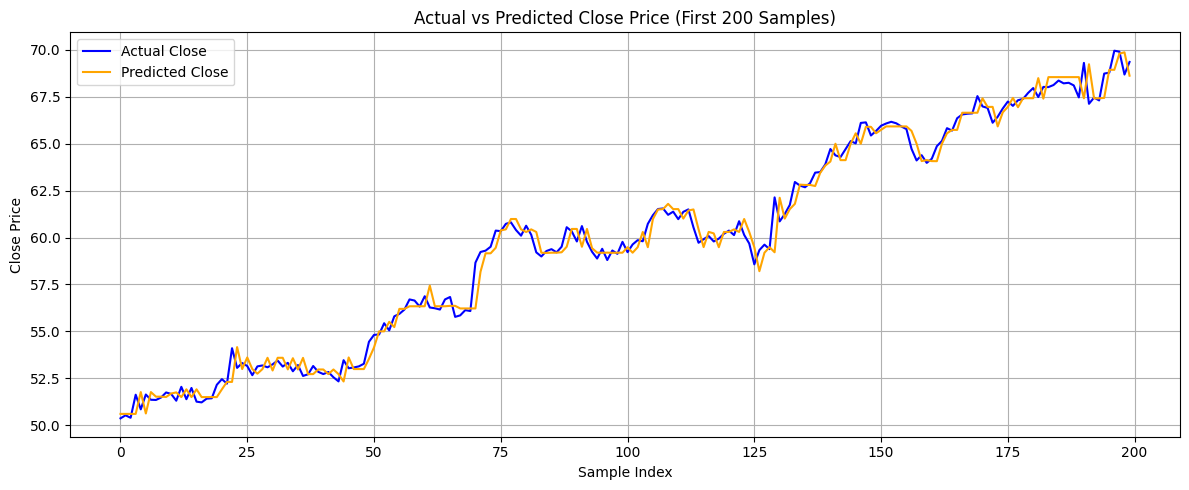

In [ ]:
# Visualize Actual vs Predicted Close Prices
plt.figure(figsize=(12, 5))
plt.plot(y_test['close'].values[:200], label='Actual Close', color='blue')
plt.plot(y_pred[:200, 3], label='Predicted Close', color='orange')
plt.legend()
plt.title("Actual vs Predicted Close Price (First 200 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.tight_layout()
plt.show()

## Check Residuals (for overfitting/underfitting)

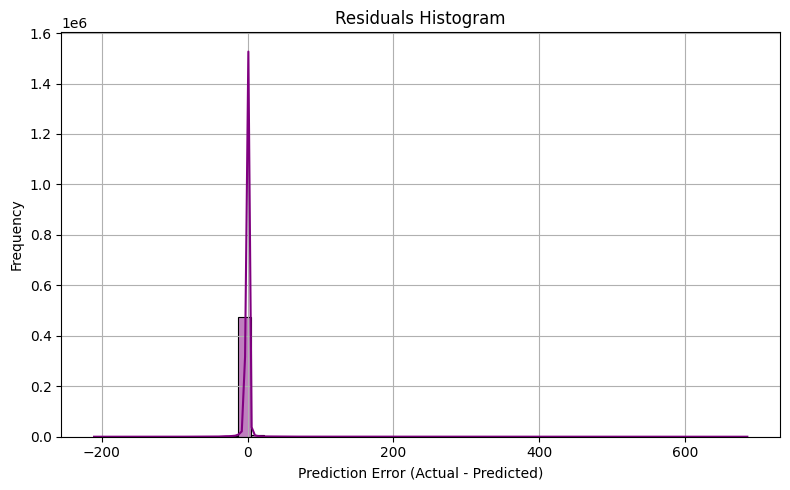

In [ ]:
# Residuals analysis
residuals = y_test.values - y_pred
residuals_flat = residuals.flatten()

plt.figure(figsize=(8, 5))
sns.histplot(residuals_flat, bins=50, kde=True, color='purple')
plt.title("Residuals Histogram")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

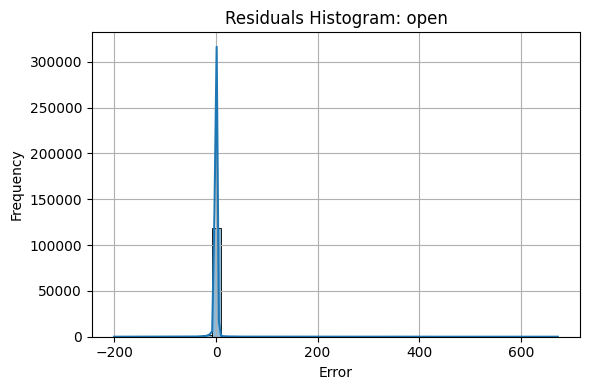

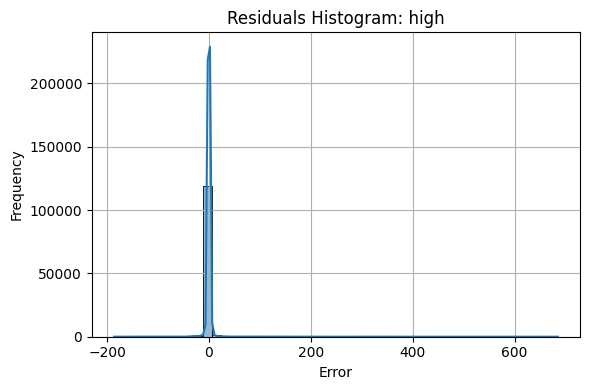

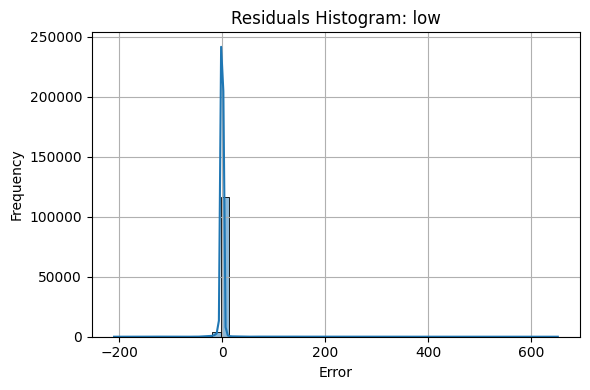

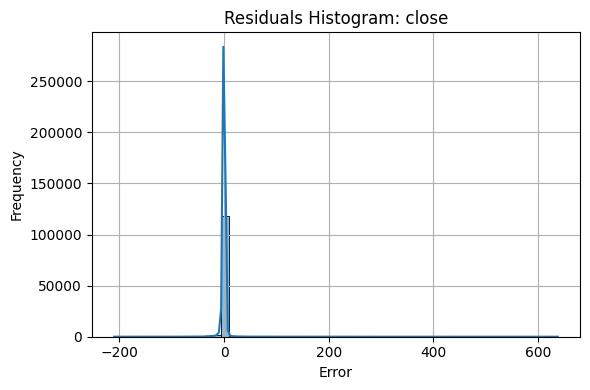

In [ ]:
# Residuals per target
target_names = ['open', 'high', 'low', 'close']
for i, name in enumerate(target_names):
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals[:, i], bins=50, kde=True)
    plt.title(f"Residuals Histogram: {name}")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()